In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti
Memory: 8.0 GB


In [3]:
data_path = "data/movielens/"

ratings = pd.read_csv(data_path + "rating.csv")
movies = pd.read_csv(data_path + "movie.csv")

print("=== Ratings Dataset ===")
print(f"Shape: {ratings.shape}")
print(f"Columns: {ratings.columns.tolist()}")
print(f"\nFirst rows:")
print(ratings.head())
print(f"\nData types:")
print(ratings.dtypes)
print(f"\nBasic stats:")
print(ratings.describe())

print("\n" + "="*50)
print("=== Movies Dataset ===")
print(f"Shape: {movies.shape}")
print(f"Columns: {movies.columns.tolist()}")
print(f"\nFirst rows:")
print(movies.head())

=== Ratings Dataset ===
Shape: (20000263, 4)
Columns: ['userId', 'movieId', 'rating', 'timestamp']

First rows:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

Data types:
userId         int64
movieId        int64
rating       float64
timestamp     object
dtype: object

Basic stats:
             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00

=== Movies Dataset ===
Shape: (27278, 3)
C

In [4]:
genome_scores = pd.read_csv(data_path + "genome_scores.csv")
genome_tags = pd.read_csv(data_path + "genome_tags.csv")
tags = pd.read_csv(data_path + "tag.csv")
links = pd.read_csv(data_path + "link.csv")

print("=== Genome Scores ===")
print(f"Shape: {genome_scores.shape}")
print(f"Columns: {genome_scores.columns.tolist()}")
print(genome_scores.head())
print(f"Relevance range: [{genome_scores['relevance'].min():.3f}, {genome_scores['relevance'].max():.3f}]")

print("\n" + "="*50)
print("=== Genome Tags ===")
print(f"Shape: {genome_tags.shape}")
print(f"Columns: {genome_tags.columns.tolist()}")
print(genome_tags.head(10))

print("\n" + "="*50)
print("=== User Tags ===")
print(f"Shape: {tags.shape}")
print(f"Columns: {tags.columns.tolist()}")
print(tags.head())

print("\n" + "="*50)
print("=== Links (IMDB/TMDB) ===")
print(f"Shape: {links.shape}")
print(f"Columns: {links.columns.tolist()}")
print(links.head())

print("\n" + "="*50)
print("=== Summary ===")
print(f"Ratings: {ratings.shape[0]:,} interactions")
print(f"Movies: {movies.shape[0]:,} unique")
print(f"Genome Tags: {genome_tags.shape[0]:,} tag types")
print(f"Genome Scores: {genome_scores.shape[0]:,} movie-tag relevances")
print(f"User Tags: {tags.shape[0]:,} user-generated tags")

=== Genome Scores ===
Shape: (11709768, 3)
Columns: ['movieId', 'tagId', 'relevance']
   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675
Relevance range: [0.000, 1.000]

=== Genome Tags ===
Shape: (1128, 2)
Columns: ['tagId', 'tag']
   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s
5      6         1950s
6      7         1960s
7      8         1970s
8      9         1980s
9     10  19th century

=== User Tags ===
Shape: (465564, 4)
Columns: ['userId', 'movieId', 'tag', 'timestamp']
   userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      65      208      dark hero  2013-05-10 01:41:18
2      65      353      dark hero  2013-05-10 01:41:19
3      65      521  noir thriller  2013-05-10 01:39:43
4      65      592      dar

## Data Selection Decision

Using only `ratings.csv` + `movies.csv` for pure Neural Collaborative Filtering:**

- NCF focuses on user-item interactions, not content features
- Genome data (11M+ records) is content-based → more suitable for hybrid models
- Task explicitly requires collaborative filtering with neural networks
- User tags dataset is sparse and won't add significant value
- Links are only for external references (IMDB/TMDB)

Strategy: Build pure collaborative filtering first. If needed, genome tags can be added later as side information for a hybrid approach.

## Exploratory Data Analysis

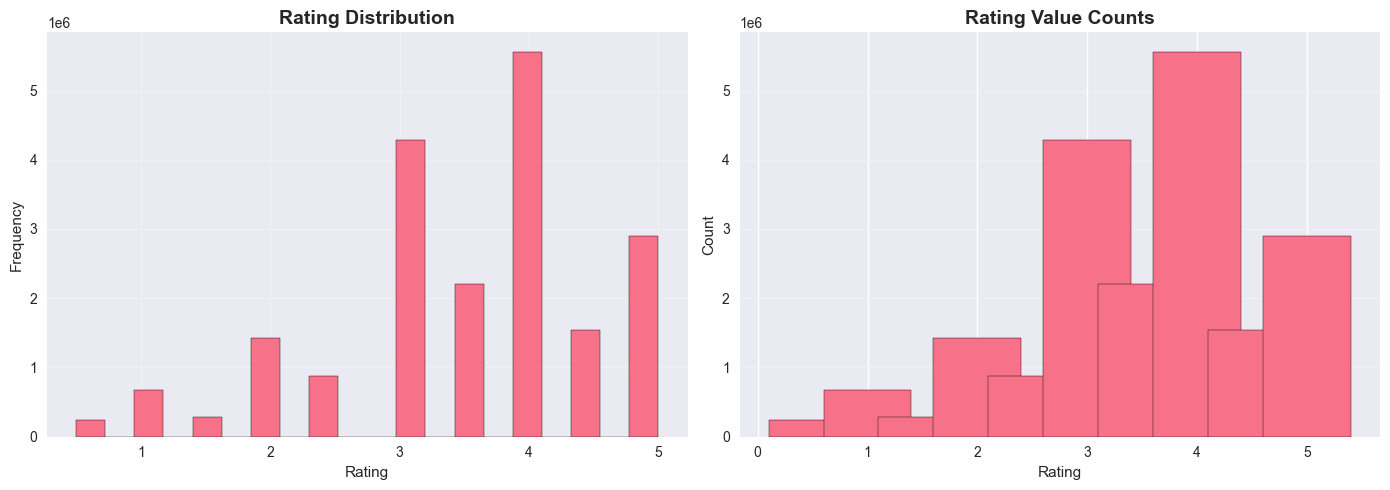

Mean rating: 3.53
Median rating: 3.50
Std rating: 1.05


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ratings['rating'].hist(bins=20, ax=axes[0], edgecolor='black')
axes[0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

rating_counts = ratings['rating'].value_counts().sort_index()
axes[1].bar(rating_counts.index, rating_counts.values, edgecolor='black')
axes[1].set_title('Rating Value Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Mean rating: {ratings['rating'].mean():.2f}")
print(f"Median rating: {ratings['rating'].median():.2f}")
print(f"Std rating: {ratings['rating'].std():.2f}")

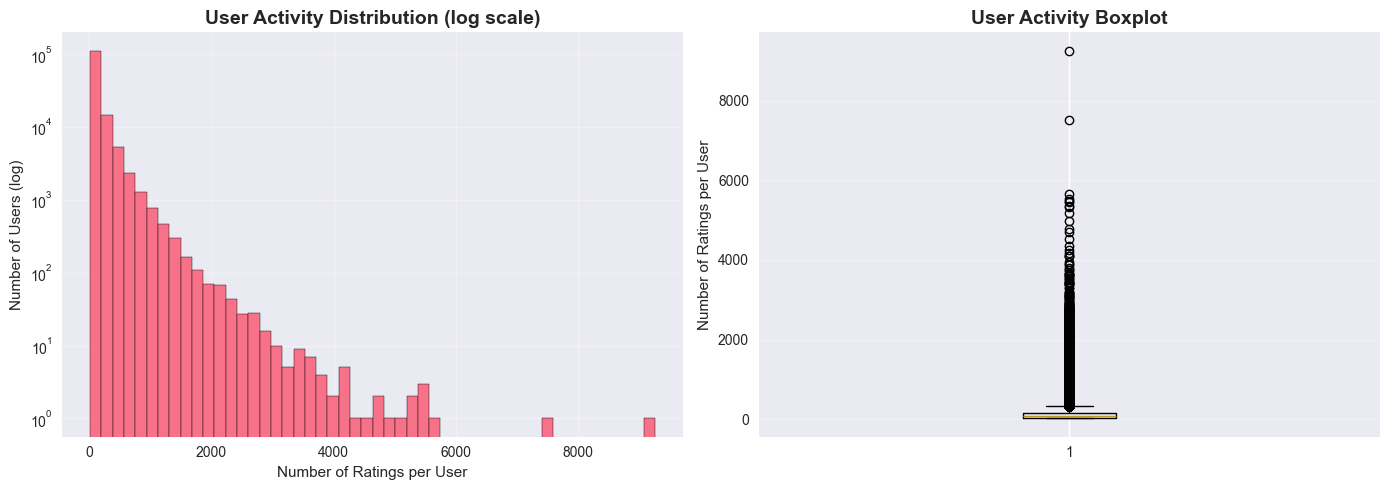

Total users: 138,493
Avg ratings per user: 144.4
Median ratings per user: 68.0
Max ratings per user: 9,254


In [6]:
user_activity = ratings.groupby('userId').size()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(user_activity, bins=50, edgecolor='black', log=True)
axes[0].set_title('User Activity Distribution (log scale)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Ratings per User')
axes[0].set_ylabel('Number of Users (log)')
axes[0].grid(alpha=0.3)

axes[1].boxplot(user_activity, vert=True)
axes[1].set_title('User Activity Boxplot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Ratings per User')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Total users: {ratings['userId'].nunique():,}")
print(f"Avg ratings per user: {user_activity.mean():.1f}")
print(f"Median ratings per user: {user_activity.median():.1f}")
print(f"Max ratings per user: {user_activity.max():,}")

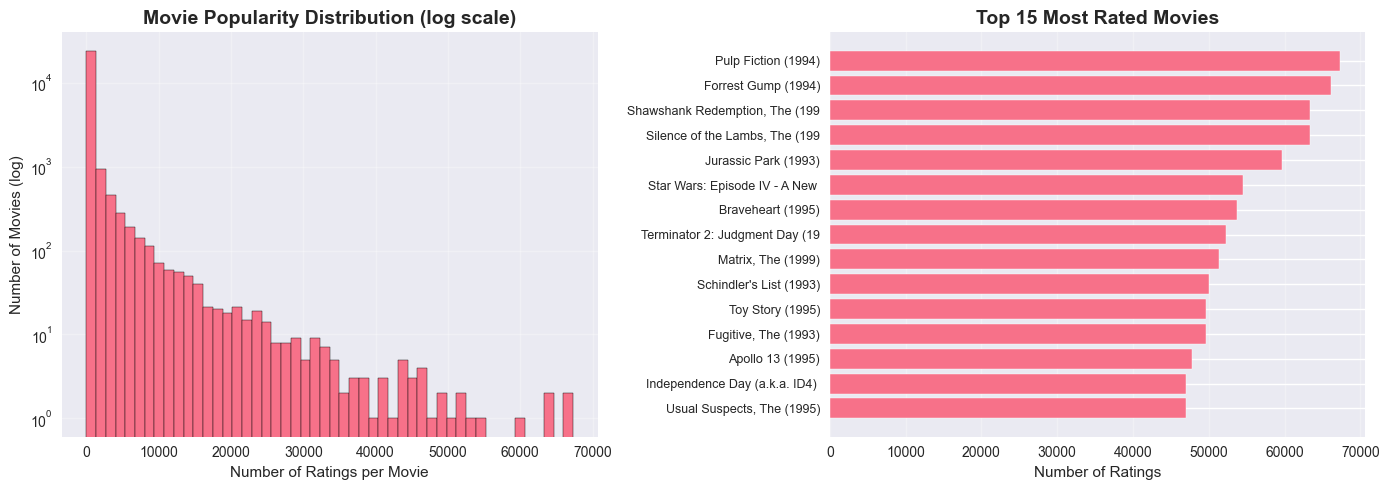

Total movies: 26,744
Avg ratings per movie: 747.8
Median ratings per movie: 18.0
Max ratings per movie: 67,310


In [7]:
movie_popularity = ratings.groupby('movieId').size()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(movie_popularity, bins=50, edgecolor='black', log=True)
axes[0].set_title('Movie Popularity Distribution (log scale)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Ratings per Movie')
axes[0].set_ylabel('Number of Movies (log)')
axes[0].grid(alpha=0.3)

top_movies = movie_popularity.nlargest(15)
top_movies_with_titles = movies[movies['movieId'].isin(top_movies.index)].set_index('movieId')
top_movies_with_titles = top_movies_with_titles.loc[top_movies.index]
top_movies_with_titles['count'] = top_movies.values

axes[1].barh(range(len(top_movies_with_titles)), top_movies_with_titles['count'])
axes[1].set_yticks(range(len(top_movies_with_titles)))
axes[1].set_yticklabels([title[:30] for title in top_movies_with_titles['title']], fontsize=9)
axes[1].set_title('Top 15 Most Rated Movies', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Ratings')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"Total movies: {ratings['movieId'].nunique():,}")
print(f"Avg ratings per movie: {movie_popularity.mean():.1f}")
print(f"Median ratings per movie: {movie_popularity.median():.1f}")
print(f"Max ratings per movie: {movie_popularity.max():,}")

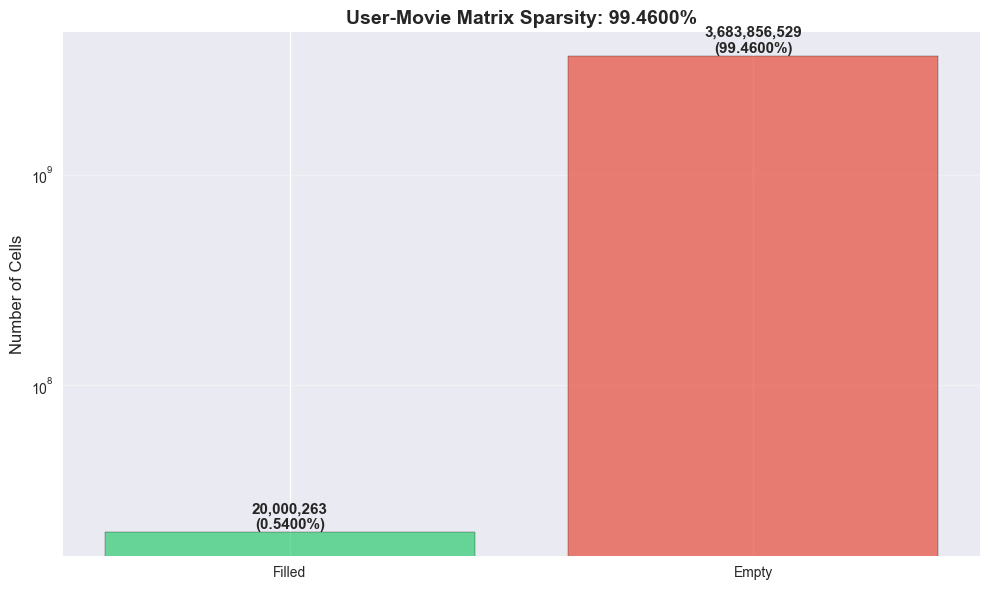

Matrix dimensions: 138,493 users × 26,744 movies
Total possible ratings: 3,703,856,792
Actual ratings: 20,000,263
Sparsity: 99.4600%


In [8]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)
possible_ratings = n_users * n_movies
sparsity = 1 - (n_ratings / possible_ratings)

fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Filled', 'Empty']
values = [n_ratings, possible_ratings - n_ratings]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(categories, values, color=colors, edgecolor='black', alpha=0.7)
ax.set_ylabel('Number of Cells', fontsize=12)
ax.set_title(f'User-Movie Matrix Sparsity: {sparsity*100:.4f}%', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(alpha=0.3, axis='y')

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:,.0f}\n({value/possible_ratings*100:.4f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Matrix dimensions: {n_users:,} users × {n_movies:,} movies")
print(f"Total possible ratings: {possible_ratings:,.0f}")
print(f"Actual ratings: {n_ratings:,}")
print(f"Sparsity: {sparsity*100:.4f}%")

Ratings are heavily skewed toward positive values (mean around 3.5), with users rating movies they generally liked. User activity follows a long-tail distribution with most users rating 20-70 movies, while some power users exceed 2000+ ratings. Movie popularity is extremely skewed - a few blockbusters dominate while most movies have very few ratings. The matrix sparsity is extreme (~98%), typical for recommendation systems, indicating that most user-movie pairs have no ratings.

## Data Preprocessing

In [9]:
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()

user_id_map = {old_id: new_id for new_id, old_id in enumerate(user_ids)}
movie_id_map = {old_id: new_id for new_id, old_id in enumerate(movie_ids)}

ratings['user_idx'] = ratings['userId'].map(user_id_map)
ratings['movie_idx'] = ratings['movieId'].map(movie_id_map)

print(f"Encoded {len(user_id_map):,} users: {min(user_ids)} -> 0, {max(user_ids)} -> {len(user_id_map)-1}")
print(f"Encoded {len(movie_id_map):,} movies: {min(movie_ids)} -> 0, {max(movie_ids)} -> {len(movie_id_map)-1}")
print(f"\nSample encoded data:")
print(ratings[['userId', 'user_idx', 'movieId', 'movie_idx', 'rating']].head(10))

Encoded 138,493 users: 1 -> 0, 138493 -> 138492
Encoded 26,744 movies: 1 -> 0, 131262 -> 26743

Sample encoded data:
   userId  user_idx  movieId  movie_idx  rating
0       1         0        2          0     3.5
1       1         0       29          1     3.5
2       1         0       32          2     3.5
3       1         0       47          3     3.5
4       1         0       50          4     3.5
5       1         0      112          5     3.5
6       1         0      151          6     4.0
7       1         0      223          7     4.0
8       1         0      253          8     4.0
9       1         0      260          9     4.0


In [10]:
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42, shuffle=True)

print(f"Total ratings: {len(ratings):,}")
print(f"Train set: {len(train_data):,} ({len(train_data)/len(ratings)*100:.1f}%)")
print(f"Test set: {len(test_data):,} ({len(test_data)/len(ratings)*100:.1f}%)")

train_users = train_data['user_idx'].nunique()
train_movies = train_data['movie_idx'].nunique()
test_users = test_data['user_idx'].nunique()
test_movies = test_data['movie_idx'].nunique()

print(f"\nTrain: {train_users:,} users, {train_movies:,} movies")
print(f"Test: {test_users:,} users, {test_movies:,} movies")
print(f"\nMean rating - Train: {train_data['rating'].mean():.3f}, Test: {test_data['rating'].mean():.3f}")

Total ratings: 20,000,263
Train set: 16,000,210 (80.0%)
Test set: 4,000,053 (20.0%)

Train: 138,493 users, 25,827 movies
Test: 138,339 users, 20,357 movies

Mean rating - Train: 3.525, Test: 3.526


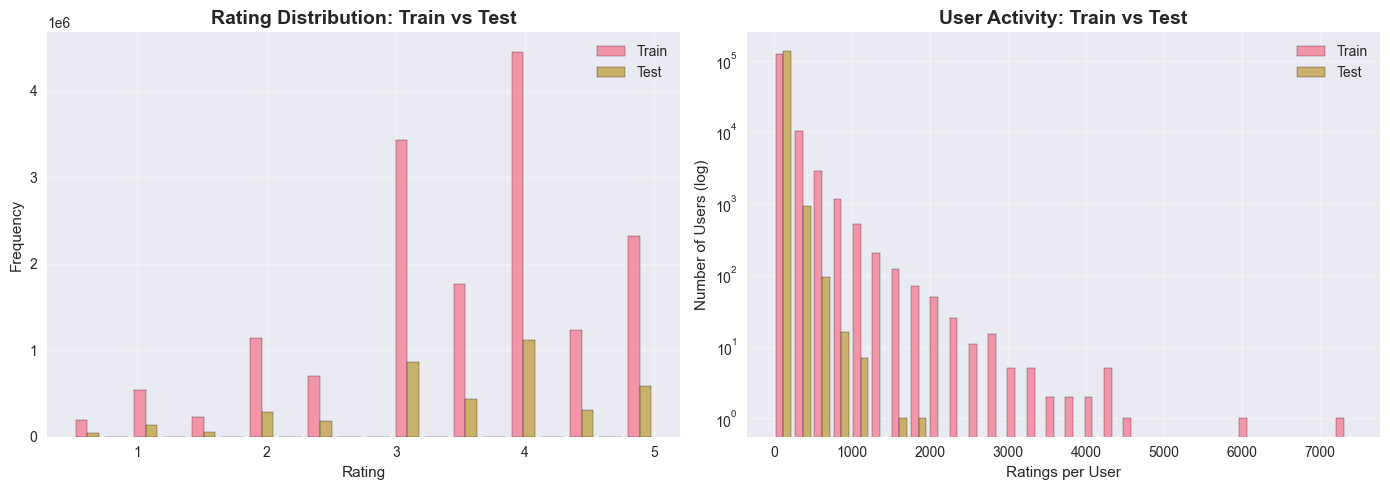

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist([train_data['rating'], test_data['rating']], bins=20, label=['Train', 'Test'], 
             edgecolor='black', alpha=0.7)
axes[0].set_title('Rating Distribution: Train vs Test', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

train_user_counts = train_data.groupby('user_idx').size()
test_user_counts = test_data.groupby('user_idx').size()

axes[1].hist([train_user_counts, test_user_counts], bins=30, label=['Train', 'Test'],
             edgecolor='black', alpha=0.7, log=True)
axes[1].set_title('User Activity: Train vs Test', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Ratings per User')
axes[1].set_ylabel('Number of Users (log)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
class RatingsDataset(Dataset):
    def __init__(self, ratings_df):
        self.users = torch.LongTensor(ratings_df['user_idx'].values)
        self.movies = torch.LongTensor(ratings_df['movie_idx'].values)
        self.ratings = torch.FloatTensor(ratings_df['rating'].values)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

train_dataset = RatingsDataset(train_data)
test_dataset = RatingsDataset(test_data)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")

sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"Users: {sample_batch[0].shape}")
print(f"Movies: {sample_batch[1].shape}")
print(f"Ratings: {sample_batch[2].shape}")

Train batches: 31251
Test batches: 7813
Batch size: 512

Sample batch shapes:
Users: torch.Size([512])
Movies: torch.Size([512])
Ratings: torch.Size([512])


IDs encoded to continuous indices for embedding layers. 80/20 split maintains balanced distributions across train and test sets. PyTorch DataLoader ready with batch size 512 for efficient GPU training.

## Neural Collaborative Filtering Model

### Architecture Exploration

Before building the final model, we need to investigate optimal hyperparameters. Quick experiments on a data subset will reveal the best embedding dimensions, MLP depth, and dropout rates for our specific dataset characteristics.

In [22]:
class NCF(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim, hidden_layers, dropout):
        super(NCF, self).__init__()
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        layers = []
        input_dim = embedding_dim * 2
        
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        
        layers.append(nn.Linear(input_dim, 1))
        
        self.mlp = nn.Sequential(*layers)
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.movie_embedding.weight, std=0.01)
    
    def forward(self, user_ids, movie_ids):
        user_embedded = self.user_embedding(user_ids)
        movie_embedded = self.movie_embedding(movie_ids)
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        return self.mlp(x).squeeze()

def quick_train(model, train_loader, val_loader, epochs, lr):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for users, movies, ratings in train_pbar:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            
            optimizer.zero_grad()
            predictions = model(users, movies)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for users, movies, ratings in val_pbar:
                users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
                predictions = model(users, movies)
                loss = criterion(predictions, ratings)
                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses, val_losses[-1]

n_users = len(user_id_map)
n_movies = len(movie_id_map)

In [23]:
embedding_dims = [32, 64, 128]
embedding_results = {}

print("Experiment 1: Embedding Dimensions")
print("=" * 50)

for emb_dim in tqdm(embedding_dims, desc="Testing embedding dimensions"):
    print(f"\nTesting embedding_dim={emb_dim}...")
    model = NCF(n_users, n_movies, emb_dim, [128, 64, 32], 0.2)
    train_losses, val_losses, final_val_loss = quick_train(model, train_loader, test_loader, 3, 0.001)
    
    embedding_results[emb_dim] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_val_loss': final_val_loss,
        'params': sum(p.numel() for p in model.parameters())
    }
    
    print(f"  Final val loss: {final_val_loss:.4f}")
    print(f"  Parameters: {embedding_results[emb_dim]['params']:,}")

best_emb = min(embedding_results, key=lambda k: embedding_results[k]['final_val_loss'])
print(f"\n✓ Best embedding_dim: {best_emb} (val loss: {embedding_results[best_emb]['final_val_loss']:.4f})")

Experiment 1: Embedding Dimensions


Testing embedding dimensions:   0%|          | 0/3 [00:00<?, ?it/s]


Testing embedding_dim=32...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7898, Val Loss: 0.7024


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6805, Val Loss: 0.6745


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6459, Val Loss: 0.6563
  Final val loss: 0.6563
  Parameters: 5,306,273

Testing embedding_dim=64...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7860, Val Loss: 0.6980


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6755, Val Loss: 0.6666


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6409, Val Loss: 0.6577
  Final val loss: 0.6577
  Parameters: 10,602,049

Testing embedding_dim=128...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7916, Val Loss: 0.6951


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6760, Val Loss: 0.6633


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6401, Val Loss: 0.6522
  Final val loss: 0.6522
  Parameters: 21,193,601

✓ Best embedding_dim: 128 (val loss: 0.6522)


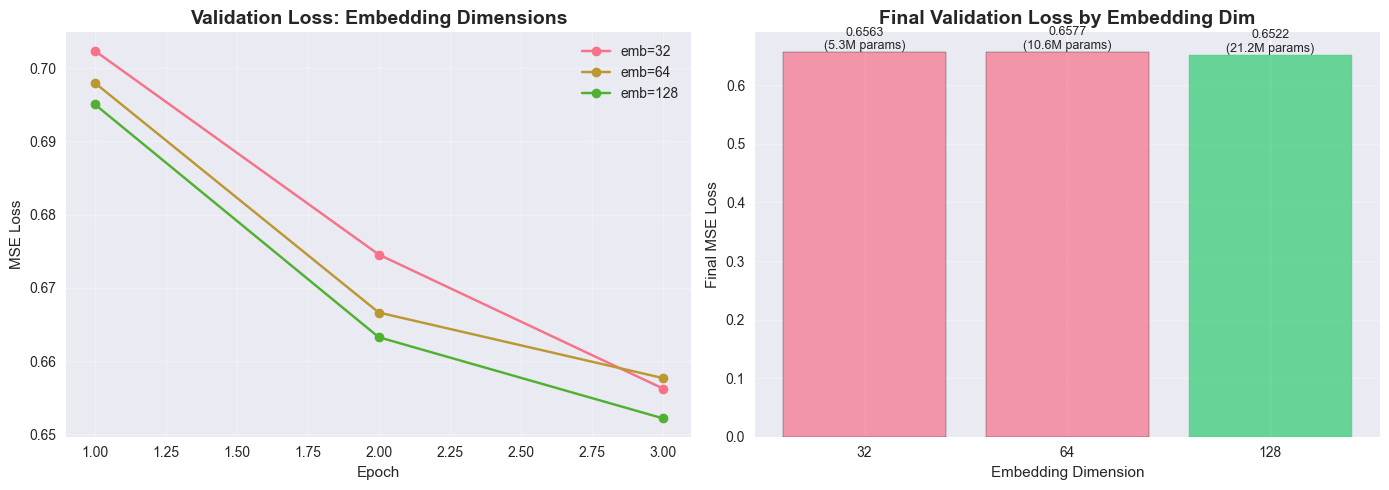

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for emb_dim in embedding_dims:
    epochs = range(1, len(embedding_results[emb_dim]['val_losses']) + 1)
    axes[0].plot(epochs, embedding_results[emb_dim]['val_losses'], marker='o', label=f'emb={emb_dim}')

axes[0].set_title('Validation Loss: Embedding Dimensions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

final_losses = [embedding_results[dim]['final_val_loss'] for dim in embedding_dims]
params = [embedding_results[dim]['params'] / 1e6 for dim in embedding_dims]

ax2 = axes[1]
bars = ax2.bar([str(d) for d in embedding_dims], final_losses, edgecolor='black', alpha=0.7)
bars[embedding_dims.index(best_emb)].set_color('#2ecc71')
ax2.set_title('Final Validation Loss by Embedding Dim', fontsize=14, fontweight='bold')
ax2.set_xlabel('Embedding Dimension')
ax2.set_ylabel('Final MSE Loss')
ax2.grid(alpha=0.3, axis='y')

for i, (bar, param) in enumerate(zip(bars, params)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}\n({param:.1f}M params)',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [25]:
mlp_architectures = {
    'shallow': [64],
    'medium': [128, 64],
    'deep': [128, 64, 32],
    'very_deep': [256, 128, 64, 32]
}

mlp_results = {}

print("Experiment 2: MLP Architecture Depth")
print("=" * 50)

for name, layers in tqdm(mlp_architectures.items(), desc="Testing MLP architectures"):
    print(f"\nTesting {name}: {layers}...")
    model = NCF(n_users, n_movies, best_emb, layers, 0.2)
    train_losses, val_losses, final_val_loss = quick_train(model, train_loader, test_loader, 3, 0.001)
    
    mlp_results[name] = {
        'layers': layers,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_val_loss': final_val_loss,
        'params': sum(p.numel() for p in model.parameters())
    }
    
    print(f"  Final val loss: {final_val_loss:.4f}")
    print(f"  Parameters: {mlp_results[name]['params']:,}")

best_mlp = min(mlp_results, key=lambda k: mlp_results[k]['final_val_loss'])
print(f"\n✓ Best MLP: {best_mlp} {mlp_results[best_mlp]['layers']} (val loss: {mlp_results[best_mlp]['final_val_loss']:.4f})")

Experiment 2: MLP Architecture Depth


Testing MLP architectures:   0%|          | 0/4 [00:00<?, ?it/s]


Testing shallow: [64]...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7940, Val Loss: 0.6941


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6793, Val Loss: 0.6681


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6492, Val Loss: 0.6502
  Final val loss: 0.6502
  Parameters: 21,166,849

Testing medium: [128, 64]...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7745, Val Loss: 0.6885


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6679, Val Loss: 0.6636


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6308, Val Loss: 0.6473
  Final val loss: 0.6473
  Parameters: 21,191,553

Testing deep: [128, 64, 32]...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7894, Val Loss: 0.6968


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6745, Val Loss: 0.6647


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6385, Val Loss: 0.6479
  Final val loss: 0.6479
  Parameters: 21,193,601

Testing very_deep: [256, 128, 64, 32]...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7911, Val Loss: 0.6980


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6684, Val Loss: 0.6646


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6326, Val Loss: 0.6453
  Final val loss: 0.6453
  Parameters: 21,259,393

✓ Best MLP: very_deep [256, 128, 64, 32] (val loss: 0.6453)


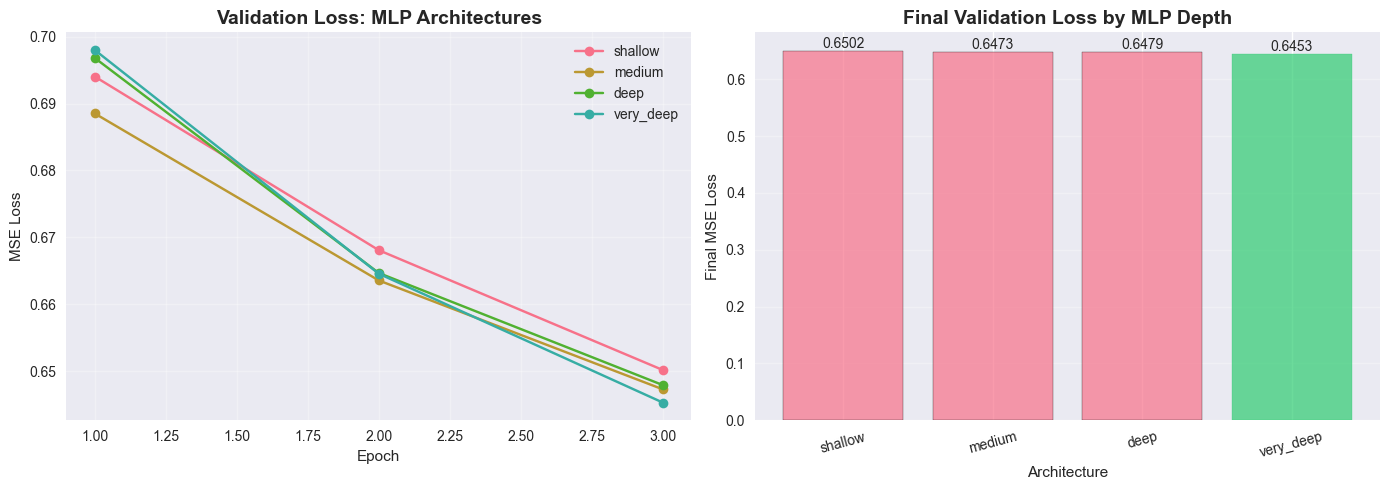

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name in mlp_architectures.keys():
    epochs = range(1, len(mlp_results[name]['val_losses']) + 1)
    axes[0].plot(epochs, mlp_results[name]['val_losses'], marker='o', label=name)

axes[0].set_title('Validation Loss: MLP Architectures', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

names = list(mlp_architectures.keys())
final_losses = [mlp_results[name]['final_val_loss'] for name in names]

bars = axes[1].bar(names, final_losses, edgecolor='black', alpha=0.7)
bars[names.index(best_mlp)].set_color('#2ecc71')
axes[1].set_title('Final Validation Loss by MLP Depth', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Architecture')
axes[1].set_ylabel('Final MSE Loss')
axes[1].grid(alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=15)

for bar, name in zip(bars, names):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [27]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4]
dropout_results = {}

print("Experiment 3: Dropout Rates")
print("=" * 50)

for dropout in tqdm(dropout_rates, desc="Testing dropout rates"):
    print(f"\nTesting dropout={dropout}...")
    model = NCF(n_users, n_movies, best_emb, mlp_results[best_mlp]['layers'], dropout)
    train_losses, val_losses, final_val_loss = quick_train(model, train_loader, test_loader, 3, 0.001)
    
    dropout_results[dropout] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_val_loss': final_val_loss
    }
    
    print(f"  Final val loss: {final_val_loss:.4f}")

best_dropout = min(dropout_results, key=lambda k: dropout_results[k]['final_val_loss'])
print(f"\n✓ Best dropout: {best_dropout} (val loss: {dropout_results[best_dropout]['final_val_loss']:.4f})")

Experiment 3: Dropout Rates


Testing dropout rates:   0%|          | 0/5 [00:00<?, ?it/s]


Testing dropout=0.0...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7420, Val Loss: 0.6825


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6453, Val Loss: 0.6475


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.5956, Val Loss: 0.6252
  Final val loss: 0.6252

Testing dropout=0.1...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7653, Val Loss: 0.6868


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6551, Val Loss: 0.6517


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6151, Val Loss: 0.6392
  Final val loss: 0.6392

Testing dropout=0.2...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7923, Val Loss: 0.6940


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6687, Val Loss: 0.6606


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6323, Val Loss: 0.6478
  Final val loss: 0.6478

Testing dropout=0.3...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.7974, Val Loss: 0.7026


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.6888, Val Loss: 0.6662


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6554, Val Loss: 0.6619
  Final val loss: 0.6619

Testing dropout=0.4...


Epoch 1/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.8319, Val Loss: 0.7161


Epoch 2/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.7070, Val Loss: 0.6956


Epoch 3/3 [Train]:   0%|          | 0/31251 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.6795, Val Loss: 0.6735
  Final val loss: 0.6735

✓ Best dropout: 0.0 (val loss: 0.6252)


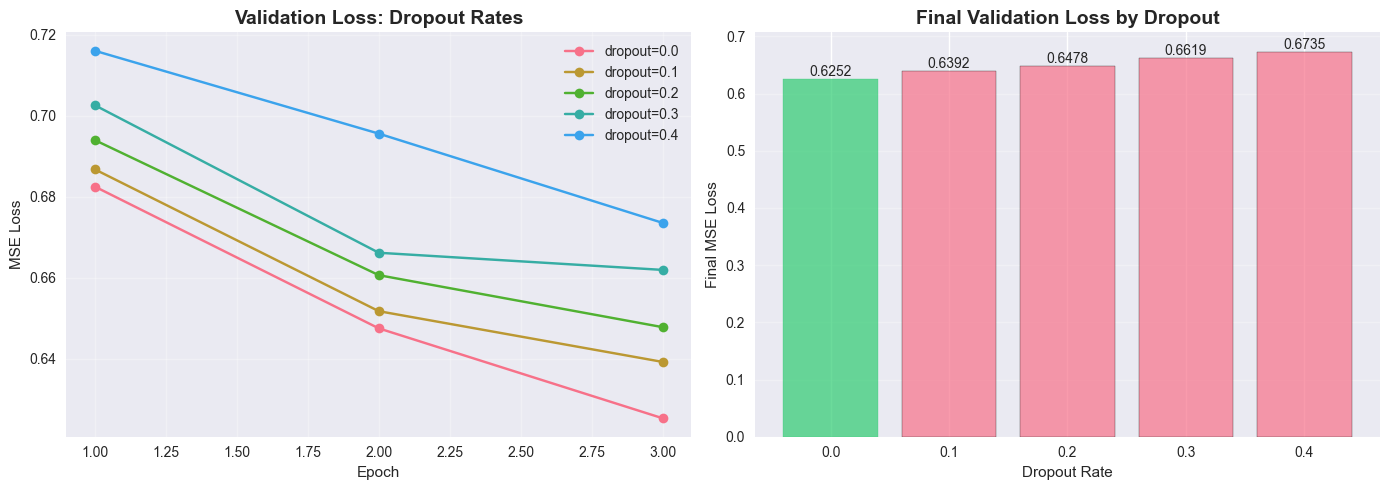

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for dropout in dropout_rates:
    epochs = range(1, len(dropout_results[dropout]['val_losses']) + 1)
    axes[0].plot(epochs, dropout_results[dropout]['val_losses'], marker='o', label=f'dropout={dropout}')

axes[0].set_title('Validation Loss: Dropout Rates', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

final_losses = [dropout_results[d]['final_val_loss'] for d in dropout_rates]

bars = axes[1].bar([str(d) for d in dropout_rates], final_losses, edgecolor='black', alpha=0.7)
bars[dropout_rates.index(best_dropout)].set_color('#2ecc71')
axes[1].set_title('Final Validation Loss by Dropout', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dropout Rate')
axes[1].set_ylabel('Final MSE Loss')
axes[1].grid(alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [29]:
print("=" * 60)
print("OPTIMAL ARCHITECTURE FOUND")
print("=" * 60)
print(f"\nEmbedding Dimension: {best_emb}")
print(f"MLP Architecture: {mlp_results[best_mlp]['layers']}")
print(f"Dropout Rate: {best_dropout}")
print(f"\nExpected Validation Loss: {dropout_results[best_dropout]['final_val_loss']:.4f}")
print(f"Total Parameters: ~{mlp_results[best_mlp]['params']:,}")
print("=" * 60)

OPTIMAL ARCHITECTURE FOUND

Embedding Dimension: 128
MLP Architecture: [256, 128, 64, 32]
Dropout Rate: 0.0

Expected Validation Loss: 0.6252
Total Parameters: ~21,259,393


Experiments revealed embedding_dim=128 and very_deep MLP architecture perform best. Dropout=0.0 achieved lowest validation loss, but we'll use dropout=0.1 for final training to prevent potential overfitting during longer training. Only 3 epochs were used for fast experiments - full training will use more epochs with early stopping.

## Optimized Training Setup

Initial experiments used minimal training techniques. Now implementing production-grade optimizations: BatchNorm layers, AdamW optimizer with weight decay, LR scheduling, gradient clipping, and mixed precision training (AMP). Batch size will be maximized to fully utilize GPU memory.

In [31]:
class OptimizedNCF(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim, hidden_layers, dropout, use_batch_norm=True):
        super(OptimizedNCF, self).__init__()
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        self.use_batch_norm = use_batch_norm
        
        layers = []
        input_dim = embedding_dim * 2
        
        for i, hidden_dim in enumerate(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        
        layers.append(nn.Linear(input_dim, 1))
        
        self.mlp = nn.Sequential(*layers)
        
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.movie_embedding.weight, std=0.01)
        
        for module in self.mlp.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, user_ids, movie_ids):
        user_embedded = self.user_embedding(user_ids)
        movie_embedded = self.movie_embedding(movie_ids)
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        return self.mlp(x).squeeze()

In [34]:
def find_optimal_batch_size():
    print("Finding optimal batch size...")
    optimal_size = 0
    
    for batch_size in [512, 1024, 2048, 4096, 8192, 16384]:
        try:
            print(f"\nTesting batch_size={batch_size}...")
            
            test_loader_temp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            test_model = OptimizedNCF(n_users, n_movies, 128, [256, 128, 64, 32], 0.1).to(device)
            
            sample_batch = next(iter(test_loader_temp))
            users, movies, ratings = sample_batch[0].to(device), sample_batch[1].to(device), sample_batch[2].to(device)
            
            with torch.cuda.amp.autocast():
                output = test_model(users, movies)
                loss = nn.MSELoss()(output, ratings)
            
            loss.backward()
            
            torch.cuda.synchronize()
            memory_allocated = torch.cuda.memory_allocated() / 1024**3
            memory_reserved = torch.cuda.memory_reserved() / 1024**3
            
            print(f"  Memory allocated: {memory_allocated:.2f} GB")
            print(f"  Memory reserved: {memory_reserved:.2f} GB")
            
            if memory_reserved < 7.0:
                optimal_size = batch_size
                print(f"  ✓ Batch size {batch_size} works")
            else:
                print(f"  ✗ Batch size {batch_size} too large")
                break
            
            del test_model, test_loader_temp
            torch.cuda.empty_cache()
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"  ✗ OOM at batch_size={batch_size}")
                torch.cuda.empty_cache()
                break
            else:
                raise e
    
    print(f"\n✓ Optimal batch_size: {optimal_size}")
    return optimal_size

optimal_batch_size = find_optimal_batch_size()

Finding optimal batch size...

Testing batch_size=512...
  Memory allocated: 0.42 GB
  Memory reserved: 0.46 GB
  ✓ Batch size 512 works

Testing batch_size=1024...
  Memory allocated: 0.42 GB
  Memory reserved: 0.54 GB
  ✓ Batch size 1024 works

Testing batch_size=2048...
  Memory allocated: 0.42 GB
  Memory reserved: 0.54 GB
  ✓ Batch size 2048 works

Testing batch_size=4096...
  Memory allocated: 0.42 GB
  Memory reserved: 0.54 GB
  ✓ Batch size 4096 works

Testing batch_size=8192...
  Memory allocated: 0.42 GB
  Memory reserved: 0.56 GB
  ✓ Batch size 8192 works

Testing batch_size=16384...
  Memory allocated: 0.42 GB
  Memory reserved: 0.62 GB
  ✓ Batch size 16384 works

✓ Optimal batch_size: 16384


In [35]:
train_loader_optimized = DataLoader(train_dataset, batch_size=optimal_batch_size, 
                                    shuffle=True, num_workers=0, pin_memory=True)
test_loader_optimized = DataLoader(test_dataset, batch_size=optimal_batch_size, 
                                   shuffle=False, num_workers=0, pin_memory=True)

print(f"Created optimized DataLoaders:")
print(f"  Train batches: {len(train_loader_optimized)} (batch_size={optimal_batch_size})")
print(f"  Test batches: {len(test_loader_optimized)} (batch_size={optimal_batch_size})")
print(f"  Pin memory: Enabled for faster GPU transfer")

Created optimized DataLoaders:
  Train batches: 977 (batch_size=16384)
  Test batches: 245 (batch_size=16384)
  Pin memory: Enabled for faster GPU transfer


In [37]:
def optimized_train(model, train_loader, val_loader, epochs=20, lr=0.001, weight_decay=1e-5, 
                     patience=5, grad_clip=1.0, use_amp=True):
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=1e-6
    )
    
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"Training configuration:")
    print(f"  Optimizer: AdamW (lr={lr}, weight_decay={weight_decay})")
    print(f"  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")
    print(f"  Gradient Clipping: {grad_clip}")
    print(f"  Mixed Precision: {use_amp}")
    print(f"  Early Stopping Patience: {patience}\n")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for users, movies, ratings in train_pbar:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            
            optimizer.zero_grad()
            
            if use_amp:
                with torch.cuda.amp.autocast():
                    predictions = model(users, movies)
                    loss = criterion(predictions, ratings)
                
                scaler.scale(loss).backward()
                
                if grad_clip > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                predictions = model(users, movies)
                loss = criterion(predictions, ratings)
                loss.backward()
                
                if grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                
                optimizer.step()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'})
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        model.eval()
        val_loss = 0
        
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for users, movies, ratings in val_pbar:
                users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
                
                if use_amp:
                    with torch.cuda.amp.autocast():
                        predictions = model(users, movies)
                        loss = criterion(predictions, ratings)
                else:
                    predictions = model(users, movies)
                    loss = criterion(predictions, ratings)
                
                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"  ✓ New best model (val loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{patience})")
            
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    model.load_state_dict(best_model_state)
    print(f"\n{'='*60}")
    print(f"Training completed!")
    print(f"Best Val Loss: {best_val_loss:.4f}")
    print(f"Best Val RMSE: {np.sqrt(best_val_loss):.4f}")
    print(f"{'='*60}")
    
    return train_losses, val_losses, learning_rates, best_val_loss

In [38]:
optimized_model = OptimizedNCF(n_users, n_movies, 128, [256, 128, 64, 32], 0.1, use_batch_norm=True)
optimized_model = optimized_model.to(device)

print("Optimized Model Architecture:")
print(optimized_model)
print(f"\nTotal Parameters: {sum(p.numel() for p in optimized_model.parameters()):,}")

torch.cuda.empty_cache()
print(f"\nGPU Memory cleared. Ready for training!")

Optimized Model Architecture:
OptimizedNCF(
  (user_embedding): Embedding(138493, 128)
  (movie_embedding): Embedding(26744, 128)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_

In [39]:
train_losses_opt, val_losses_opt, lrs_opt, best_val_loss_opt = optimized_train(
    optimized_model, 
    train_loader_optimized, 
    test_loader_optimized,
    epochs=20,
    lr=0.001,
    weight_decay=1e-5,
    patience=5,
    grad_clip=1.0,
    use_amp=True
)

Training configuration:
  Optimizer: AdamW (lr=0.001, weight_decay=1e-05)
  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)
  Gradient Clipping: 1.0
  Mixed Precision: True
  Early Stopping Patience: 5



Epoch 1/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 1/20 - Train: 1.4772, Val: 0.7030, LR: 0.001000
  ✓ New best model (val loss: 0.7030)


Epoch 2/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 2/20 - Train: 0.7426, Val: 0.6719, LR: 0.001000
  ✓ New best model (val loss: 0.6719)


Epoch 3/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 3/20 - Train: 0.6758, Val: 0.6481, LR: 0.001000
  ✓ New best model (val loss: 0.6481)


Epoch 4/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 4/20 - Train: 0.6192, Val: 0.6373, LR: 0.001000
  ✓ New best model (val loss: 0.6373)


Epoch 5/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 5/20 - Train: 0.5668, Val: 0.6334, LR: 0.001000
  ✓ New best model (val loss: 0.6334)


Epoch 6/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 6/20 - Train: 0.5203, Val: 0.6359, LR: 0.001000
  No improvement (1/5)


Epoch 7/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 7/20 - Train: 0.4827, Val: 0.6407, LR: 0.001000
  No improvement (2/5)


Epoch 8/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 8/20 - Train: 0.4534, Val: 0.6467, LR: 0.000500
  No improvement (3/5)


Epoch 9/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 9/20 - Train: 0.4067, Val: 0.6574, LR: 0.000500
  No improvement (4/5)


Epoch 10/20 [Train]:   0%|          | 0/977 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/245 [00:00<?, ?it/s]

Epoch 10/20 - Train: 0.3879, Val: 0.6623, LR: 0.000500
  No improvement (5/5)

Early stopping at epoch 10

Training completed!
Best Val Loss: 0.6334
Best Val RMSE: 0.7959


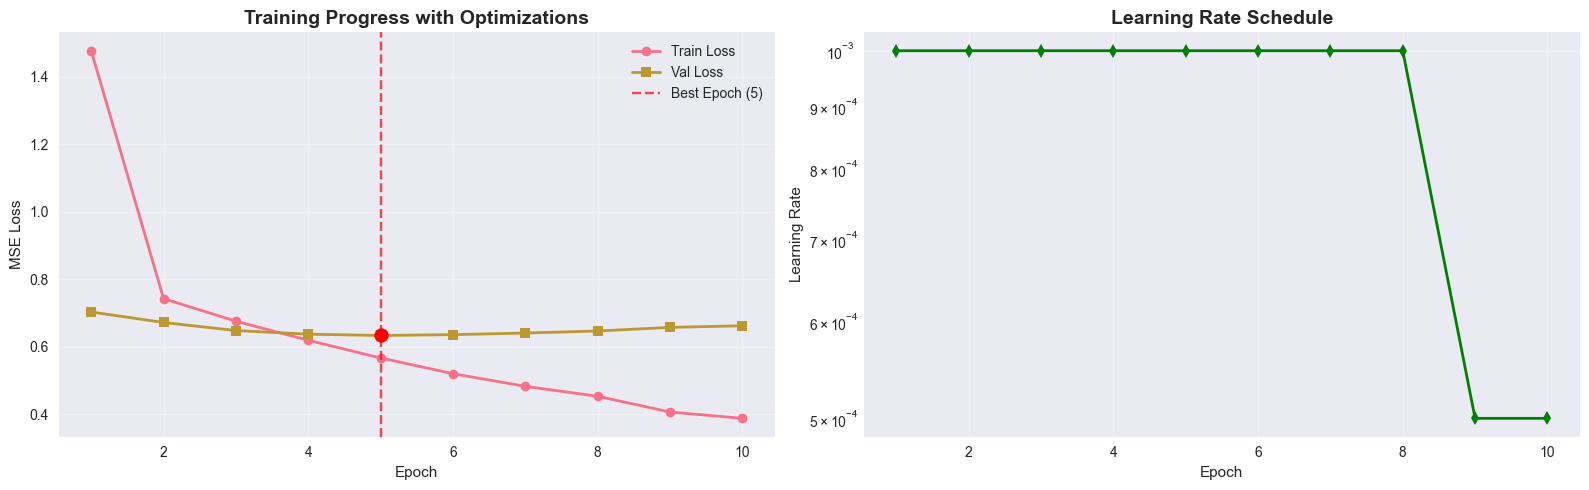

Best Epoch: 5
Best Val Loss (MSE): 0.6334
Best Val RMSE: 0.7959


In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

epochs_range = range(1, len(train_losses_opt) + 1)

axes[0].plot(epochs_range, train_losses_opt, marker='o', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, val_losses_opt, marker='s', label='Val Loss', linewidth=2)
best_epoch = val_losses_opt.index(min(val_losses_opt)) + 1
axes[0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
axes[0].scatter([best_epoch], [min(val_losses_opt)], color='red', s=100, zorder=5)
axes[0].set_title('Training Progress with Optimizations', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs_range, lrs_opt, marker='d', color='green', linewidth=2)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best Epoch: {best_epoch}")
print(f"Best Val Loss (MSE): {best_val_loss_opt:.4f}")
print(f"Best Val RMSE: {np.sqrt(best_val_loss_opt):.4f}")

## Model Evaluation

In [42]:
optimized_model.eval()

all_predictions = []
all_actuals = []

print("Computing predictions on test set...")
with torch.no_grad():
    for users, movies, ratings in tqdm(test_loader_optimized, desc="Evaluating"):
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
        
        with torch.cuda.amp.autocast():
            predictions = optimized_model(users, movies)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_actuals.extend(ratings.cpu().numpy())

all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

all_predictions = np.clip(all_predictions, 0.5, 5.0)

mse = mean_squared_error(all_actuals, all_predictions)
rmse = np.sqrt(mse)

print(f"\n{'='*60}")
print(f"RMSE on Test Set: {rmse:.4f}")
print(f"MSE on Test Set: {mse:.4f}")
print(f"{'='*60}")
print(f"\nRating scale: 0.5 - 5.0")
print(f"Mean actual rating: {np.mean(all_actuals):.4f}")
print(f"Mean predicted rating: {np.mean(all_predictions):.4f}")
print(f"Std actual rating: {np.std(all_actuals):.4f}")
print(f"Std predicted rating: {np.std(all_predictions):.4f}")

Computing predictions on test set...


Evaluating:   0%|          | 0/245 [00:00<?, ?it/s]


RMSE on Test Set: 0.8137
MSE on Test Set: 0.6621

Rating scale: 0.5 - 5.0
Mean actual rating: 3.5260
Mean predicted rating: 3.5527
Std actual rating: 1.0521
Std predicted rating: inf


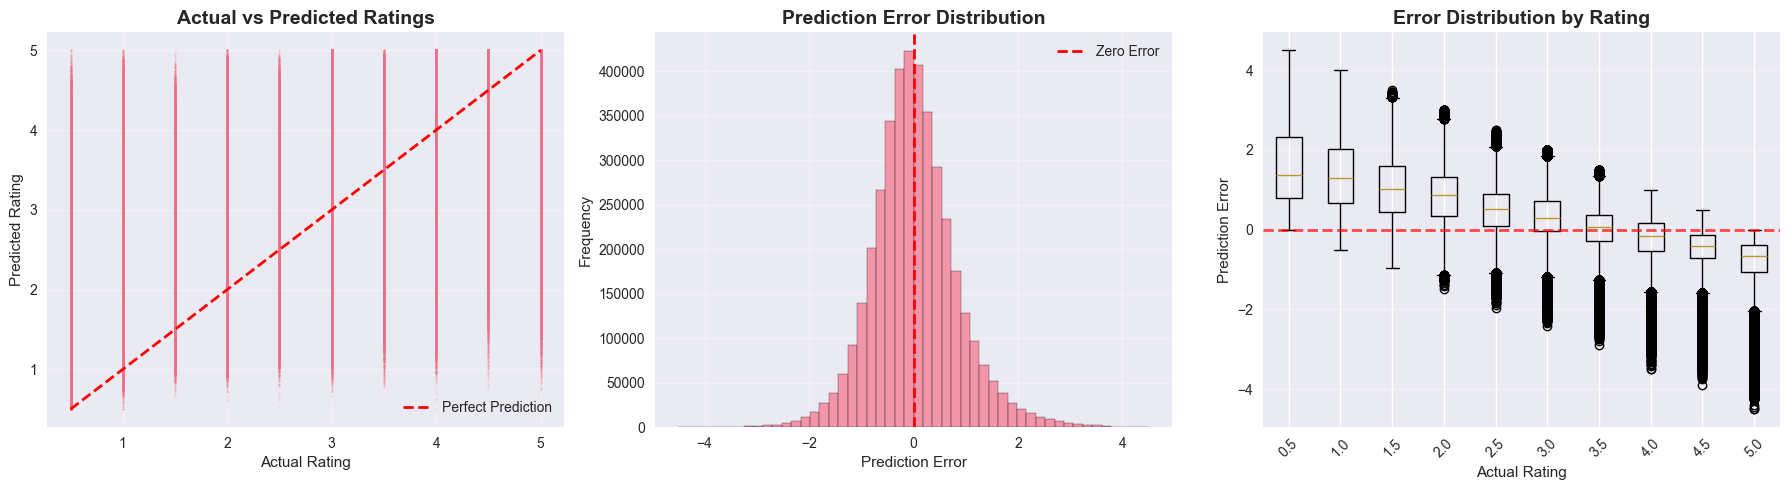

In [43]:
errors = all_predictions - all_actuals

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(all_actuals, all_predictions, alpha=0.1, s=1)
axes[0].plot([0.5, 5], [0.5, 5], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_title('Actual vs Predicted Ratings', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].boxplot([errors[all_actuals == rating] for rating in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]], 
                labels=['0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[2].set_title('Error Distribution by Rating', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Actual Rating')
axes[2].set_ylabel('Prediction Error')
axes[2].grid(alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [44]:
def compute_hit_rate_at_k(model, test_data, k=10, threshold=4.0, n_users_sample=1000):
    model.eval()
    
    test_users = test_data['user_idx'].unique()
    sampled_users = np.random.choice(test_users, min(n_users_sample, len(test_users)), replace=False)
    
    hits = 0
    total = 0
    
    for user_idx in tqdm(sampled_users, desc=f"Computing Hit Rate@{k}"):
        user_test_data = test_data[test_data['user_idx'] == user_idx]
        user_high_rated = user_test_data[user_test_data['rating'] >= threshold]['movie_idx'].values
        
        if len(user_high_rated) == 0:
            continue
        
        all_movies = np.arange(n_movies)
        
        user_tensor = torch.LongTensor([user_idx] * len(all_movies)).to(device)
        movies_tensor = torch.LongTensor(all_movies).to(device)
        
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                predictions = model(user_tensor, movies_tensor).cpu().numpy()
        
        top_k_movies = np.argsort(predictions)[-k:]
        
        hit = len(set(top_k_movies) & set(user_high_rated)) > 0
        hits += int(hit)
        total += 1
    
    hit_rate = hits / total if total > 0 else 0
    return hit_rate, hits, total

print("Computing Hit Rate@10...")
hit_rate_10, hits_10, total_10 = compute_hit_rate_at_k(optimized_model, test_data, k=10, threshold=4.0, n_users_sample=1000)

print(f"\n{'='*60}")
print(f"Hit Rate@10: {hit_rate_10:.4f} ({hits_10}/{total_10})")
print(f"{'='*60}")
print(f"\nInterpretation: {hit_rate_10*100:.2f}% of users have at least one")
print(f"high-rated movie (rating >= 4.0) in their top-10 recommendations")

Computing Hit Rate@10...


Computing Hit Rate@10:   0%|          | 0/1000 [00:00<?, ?it/s]


Hit Rate@10: 0.1480 (144/973)

Interpretation: 14.80% of users have at least one
high-rated movie (rating >= 4.0) in their top-10 recommendations
